<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ME539-Scientific-Machine-Learning/blob/main/Shaunak_Mukherjee_ME539_Homework7_PartB_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7 - Part B

*Note that there are two different notebooks for HW assignment 7. This is part B. There will be two different assignments in gradescope for each part. The deadlines are the same for both parts.*

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [ ]:
# Run this on Google colab
!pip install pyro-ppl

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

## Problem 1  - Bayesian Linear regression on steroids

The purpose of this problem is to demonstrate that we have learned enough to do very complicated things.
In the first part, we will do Bayesian linear regression with radial basis functions (RBFs) in which we characterize the posterior of all parameters, including the length-scales of the RBFs.
In the second part, we are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.

We need to write some `pytorch` code to compute the design matrix. This is absolutely necessary so that `pyro` can differentiate through all expressions.

In [ ]:
class RadialBasisFunctions(torch.nn.Module):
    """Radial basis functions basis.

    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed length scale.
    """
    def __init__(self, X, ell):
        super().__init__()
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def forward(self, x):
        distances = torch.cdist(x, self.X)
        return torch.exp(-.5 * distances ** 2 / self.ell ** 2)

Here is how you can use them:

In [ ]:
# Make the basis
x_centers = torch.linspace(-1, 1, 10).unsqueeze(-1)
ell = 0.2
basis = RadialBasisFunctions(x_centers, ell)

# Some points (need to be N x 1)
x = torch.linspace(-1, 1, 100).unsqueeze(-1)

# Evaluate the basis
Phi = basis(x)

# Here is the shape of Phi
print(Phi.shape)

torch.Size([100, 10])


Here is how they look like:

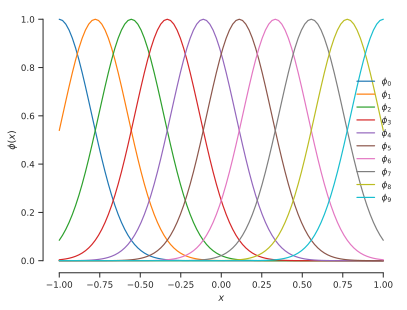

In [ ]:
fig, ax = plt.subplots()
for i in range(Phi.shape[1]):
    ax.plot(x, Phi[:, i], label=f"$\phi_{i}$")
ax.set(xlabel="$x$", ylabel="$\phi(x)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Part A - Hierarchical Bayesian linear regression with input-independent noise

We will analyze the motorcycle dataset. The data is loaded below.

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)

We will work with the scaled data:

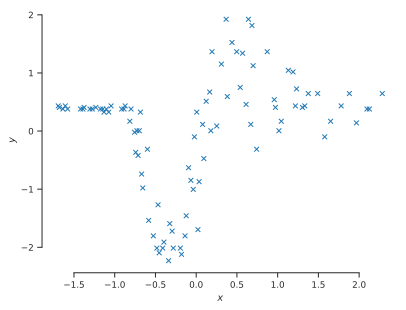

In [ ]:
from sklearn.preprocessing import StandardScaler

data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)

fig, ax = plt.subplots()
ax.plot(X, Y, 'x')
ax.set(xlabel="$x$", ylabel="$y$")
sns.despine(trim=True);

### Part A.I

Your goal is to implement the model described below.
We use the radial basis functions (`RadialBasisFunction`) with centers, $x_i$ at $m=50$ equidistant points between the minimum and maximum of the observed inputs:

$$
\phi_i(x;\ell) = \exp \left( - \frac{(x - x_i)^2}{2 \ell^2} \right),
$$

for $i=1,\dots,m$.
We denote the vector of RBFs evaluated at $x$ as $\boldsymbol{\phi}(x;\ell)$.

We are not going to pick the length-scales $\ell$ by hand. Instead, we will put a prior on it:

$$
\ell \sim \text{Exponential}(1).
$$

The corresponding weights have priors:

$$
w_j | \alpha_i \sim N(0, \alpha_j^2),
$$

and its $\alpha_j$ has a prior:

$$
\alpha_j \sim \text{Exponential}(1),
$$

for $j=1,\dots,m$.

Denote our data as:

$$
x_{1:n} = (x_1, \dots, x_n)^T,\;\text{(inputs)},
$$

and

$$
y_{1:n} = (y_1, \dots, y_n)^T,\;\text{(outputs)}.
$$

The likelihood of the data is:

$$
y_i | \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2),
$$

for $i=1,\dots,n$.

$$
y_n | \ell, \mathbf{w}, \sigma \sim N(\mathbf{w}^T \boldsymbol{\phi}(x_n;\ell), \sigma^2).
$$

Complete the `pyro` implementation of that model:

**Answer:**

In [ ]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        # Notice below that dist.Normal needs the standard deviation - not the variance
        # We follow a different convention in the lecture notes
        w = pyro.sample("w", dist.Normal(0.0, alpha))
    ell = pyro.sample("ell", dist.Exponential(1.0))
    # Hint: Look at alpha.
    sigma = pyro.sample("sigma", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(Phi @ w, sigma), obs=y)
    # Notice that I'm making the model return all the variables that I have made.
    # This is not essential for characterizing the posterior, but it does reduce redundant code
    # when we are trying to get the posterior predictive.
    return locals()

The graph will help to understand the model:

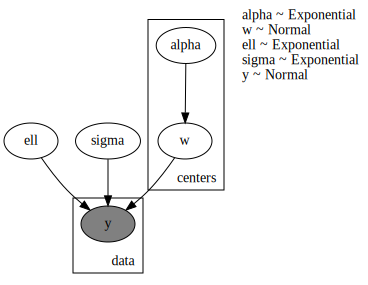

In [ ]:
pyro.render_model(model, (X, Y), render_distributions=True)

Use `pyro.infer.autoguide.AutoDiagonalNormal` to make the guide:

In [ ]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

We will use variational inference. Here is the training code from the hans-on activity:

In [ ]:
def train(model, guide, data, num_iter=5_000):
    """Train a model with a guide.

    Arguments
    ---------
    model    -- The model to train.
    guide    -- The guide to train.
    data     -- The data to train the model with.
    num_iter -- The number of iterations to train.

    Returns
    -------
    elbos -- The ELBOs for each iteration.
    param_store -- The parameters of the model.
    """

    pyro.clear_param_store()

    optimizer = pyro.optim.Adam({"lr": 0.001})

    svi = pyro.infer.SVI(
        model,
        guide,
        optimizer,
        loss=pyro.infer.JitTrace_ELBO()
    )

    elbos = []
    for i in range(num_iter):
        loss = svi.step(*data)
        elbos.append(-loss)
        if i % 1_000 == 0:
            print(f"Iteration: {i} Loss: {loss}")

    return elbos, pyro.get_param_store()

### Part A.II

Train the model for 20,000 iterations. Call the `train()` function we defined above to do it.
Make sure you store the returned elbo values because you will need them later.

**Answer:**

In [ ]:
num_iterations = 20000
elbos, param_store = train(model, guide, (X, Y), num_iterations)

Iteration: 0 Loss: 410.78228759765625
Iteration: 1000 Loss: 243.140625
Iteration: 2000 Loss: 182.77688598632812
Iteration: 3000 Loss: 157.55841064453125
Iteration: 4000 Loss: 130.44244384765625
Iteration: 5000 Loss: 135.60162353515625
Iteration: 6000 Loss: 135.5852813720703
Iteration: 7000 Loss: 126.8989486694336
Iteration: 8000 Loss: 118.39689636230469
Iteration: 9000 Loss: 123.00052642822266
Iteration: 10000 Loss: 119.79803466796875
Iteration: 11000 Loss: 132.26881408691406
Iteration: 12000 Loss: 122.23580932617188
Iteration: 13000 Loss: 132.99557495117188
Iteration: 14000 Loss: 130.3395233154297
Iteration: 15000 Loss: 134.26918029785156
Iteration: 16000 Loss: 128.31068420410156
Iteration: 17000 Loss: 118.94435119628906
Iteration: 18000 Loss: 136.9231719970703
Iteration: 19000 Loss: 129.30081176757812


### Part A.III

Plot the evolution of the ELBO.

**Answer:**

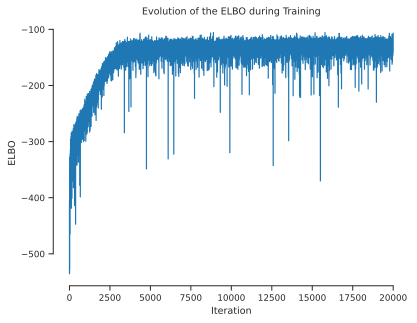

In [ ]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set(xlabel="Iteration", ylabel="ELBO")
ax.set_title("Evolution of the ELBO during Training")
sns.despine(trim=True)
plt.show()

### Part A.IV

Take 1,000 posterior samples.

**Answer:**

I'm giving you this one because it is a bit tricky. You need to use the `pyro.infer.Predictive` class to do it. Here is how you can use it:

In [ ]:
post_samples = pyro.infer.Predictive(model, guide=guide, num_samples=1000)(X, Y)
# Just modify the call to get the right number of samples

### Part A.V

Plot the histograms of the posteriors of $\ell$, $\sigma$, $\alpha_{10}$ and $w_{10}$.

**Answer:**

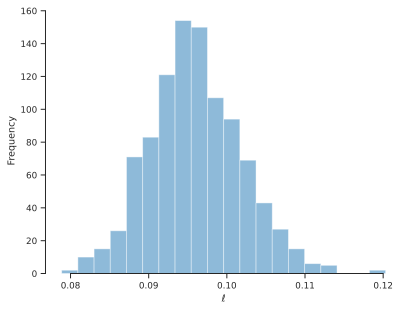

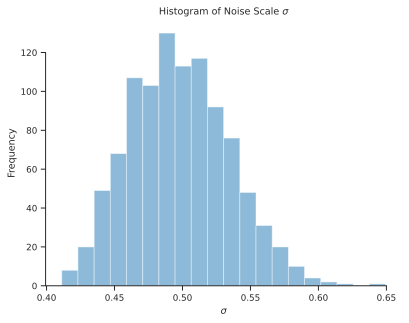

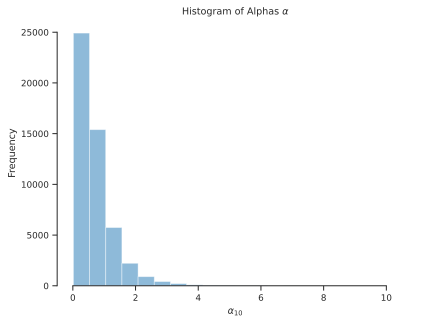

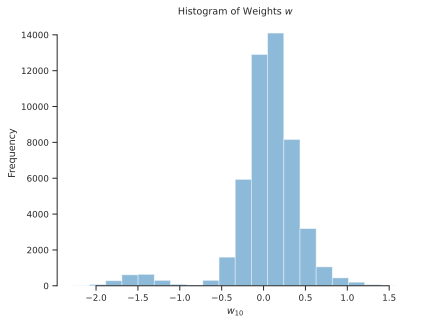

In [ ]:
# First, here is how to extract the samples.
ell = post_samples["ell"]
# You can do `post_samples.keys()` to see all the keys.
# But they should correspond to the names of the latent variables in the model.
sigma = post_samples["sigma"]
alphas = post_samples['alpha']
ws = post_samples["w"]

# Here is the code to make the histogram for the length scale.
fig, ax = plt.subplots()
# **VERY IMPORTANT** - You need to detach the tensor from the computational graph.
# Otherwise, you will get very very strange behavior.
ax.hist(ell.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\ell$", ylabel="Frequency")
sns.despine(trim=True);

# Noise scale (sigma)
fig, ax = plt.subplots()
ax.hist(sigma.detach().numpy(), bins=20, alpha=.5)
ax.set(xlabel=r"$\sigma$", ylabel="Frequency")
ax.set_title("Histogram of Noise Scale $\sigma$")
sns.despine(trim=True)
plt.show()

# Alphas
fig, ax = plt.subplots()
ax.hist(alphas.detach().numpy().flatten(), bins=20, alpha=.5)
ax.set(xlabel=r"$\alpha_{10}$", ylabel="Frequency")
ax.set_title("Histogram of Alphas $\\alpha$")
sns.despine(trim=True)
plt.show()

# Weights (ws)
fig, ax = plt.subplots()
ax.hist(ws.detach().numpy().flatten(), bins=20, alpha=.5)
ax.set(xlabel=r"$w_{10}$", ylabel="Frequency")
ax.set_title("Histogram of Weights $w$")
sns.despine(trim=True)
plt.show()

### Part A.VI

Let's extend them model to make predictions.

**Answer:**

In [ ]:
def predictive_model(X, y, num_centers=50):
    # First we run the original model get all the variables
    params = model(X, y, num_centers)
    # Here is how you can access the variables
    w = params["w"]
    ell = params["ell"] # Access the length scale
    sigma = params["sigma"] # Access the standard deviation of the measurement noise
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1) # Access the centers of the radial basis functions
    # Here are the points where we want to make predictions
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    # Evaluate the basis on the prediction points
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    # Make the predictions - we use a deterministic node here because we want to
    # save the results of the predictions.
    predictions = pyro.deterministic("predictions", Phi @ w)
    # Finally, we add the measurement noise
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part A.VII

Extract the posterior predictive distribution using 10,000 samples. Separate aleatory and epistemic uncertainty.

**Answer:**

In [ ]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10_000)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"].detach().numpy()
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

### Part A.VIII

Plot the data, the median, the 95% credible interval of epistemic uncertainty and the 95% credible interval of aleatory uncertainty, along with five samples from the posterior.

**Answer:**

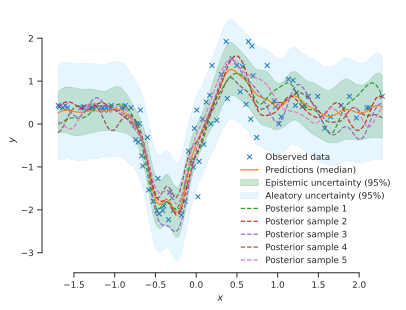

In [ ]:
# Select 5 random samples from the posterior
num_samples_to_plot = 5
sample_indices = np.random.choice(predictions.shape[0], num_samples_to_plot, replace=False)
posterior_samples = predictions[sample_indices]

# Plotting the results
fig, ax = plt.subplots()
ax.plot(X.numpy(), Y.numpy(), 'x', label="Observed data")
ax.plot(xs.numpy().flatten(), p_500.flatten(), label="Predictions (median)")
ax.fill_between(xs.numpy().flatten(), p_025.flatten(), p_975.flatten(), color='g', alpha=0.2, label="Epistemic uncertainty (95%)")
ax.fill_between(xs.numpy().flatten(), ap_025.flatten(), ap_975.flatten(), color='lightskyblue', alpha=0.2, label="Aleatory uncertainty (95%)")

# Plot the posterior samples
for i, sample in enumerate(posterior_samples):
    ax.plot(xs.numpy().flatten(), sample.flatten(), linestyle='--', label=f"Posterior sample {i+1}")

ax.set(xlabel="$x$", ylabel="$y$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)
plt.show()


### Part B - Heteroscedastic regression

We are going to build a model that has an input-varying noise. Such models are called heteroscedastic models.
Here I will let you do more of the work.

Everything is as before for $\ell$, the $\alpha_j$'s, and the $w_j$'s.
We now introduce a model for the noise that is input dependent.
It will use the same RBFs as the mean function.
But let's use a different length-scale, $\ell_\sigma$.
So, we add:

$$
\ell_\sigma \sim \text{Exponential}(1),
$$

$$
\alpha_{\sigma,j} \sim \text{Exponential}(1),
$$

and

$$
w_{\sigma,j} | \alpha_{\sigma,j} \sim N(0, \alpha_{\sigma,j}^2),
$$

for $j=1,\dots,m$.

Our model for the input-dependent noise variance is:

$$
\sigma(x;\mathbf{w}_\sigma,\ell) = \exp\left(\mathbf{w}_\sigma^T \boldsymbol{\phi}(x;\ell_\sigma)\right).
$$

So, the likelihood of the data is:

$$
y_i | \mathbf{w}, \mathbf{w}_\sigma \sim N\left(\mathbf{w}^T \boldsymbol{\phi}(x_i;\ell), \sigma^2(x_i;\mathbf{w}_\sigma,\ell)\right),
$$

You will implement this model.

### Part B.I

Complete the code below:

In [ ]:
def model(X, y, num_centers=50):
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))
        # Let's add the generalized linear model for the log noise.
        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("w_noise", dist.Normal(0.0, alpha_noise))
    ell = pyro.sample("ell", dist.Exponential(1.))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.0))
    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)
    # This is the new part 2/2
    model_mean = Phi @ w
    sigma = torch.exp(Phi_noise @ w_noise)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("y", dist.Normal(model_mean, sigma), obs=y)
    return locals()

Make a `pyro.infer.autoguide.AutoDiagonalNormal` guide:

In [ ]:
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

Make the graph of the model using `pyro` functionality:

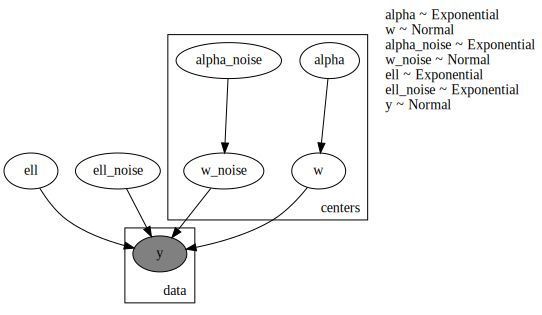

In [ ]:
pyro.render_model(model, model_args=(X, Y), render_distributions=True)

### Part B.II

Train the model using 20,000 iterations. Then plot the evolution of the ELBO.

**Answer:**

In [ ]:
num_iterations = 20_000
elbos, param_store = train(model, guide, (X, Y), num_iterations)

Iteration: 0 Loss: 777.52685546875
Iteration: 1000 Loss: 330.9578857421875
Iteration: 2000 Loss: 228.11146545410156
Iteration: 3000 Loss: 200.93667602539062
Iteration: 4000 Loss: 171.5982666015625
Iteration: 5000 Loss: 172.60302734375
Iteration: 6000 Loss: 189.3479766845703
Iteration: 7000 Loss: 172.86245727539062
Iteration: 8000 Loss: 186.36134338378906
Iteration: 9000 Loss: 166.66912841796875
Iteration: 10000 Loss: 162.48046875
Iteration: 11000 Loss: 165.08642578125
Iteration: 12000 Loss: 244.0706329345703
Iteration: 13000 Loss: 163.078125
Iteration: 14000 Loss: 175.73849487304688
Iteration: 15000 Loss: 188.05503845214844
Iteration: 16000 Loss: 174.49105834960938
Iteration: 17000 Loss: 194.36770629882812
Iteration: 18000 Loss: 216.89016723632812
Iteration: 19000 Loss: 170.76805114746094


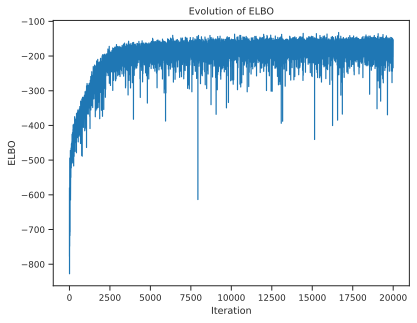

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the evolution of the ELBO
plt.figure()
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Evolution of ELBO")
plt.show()
sns.despine(trim=True);

### Part B.III

Extend the model to make predictions.

**Answer:**

In [ ]:
def predictive_model(X, y, num_centers=50):
    params = model(X, y, num_centers)
    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

### Part B.IV

Now, make predictions and calculate the epistemic and aleatory uncertainties as in part A.VII.

**Answer:**

In [ ]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10_000)(X, Y)
# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"].detach().numpy()
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)


### Part B.V

Make the same plot as in part A.VIII.

**Answer:**

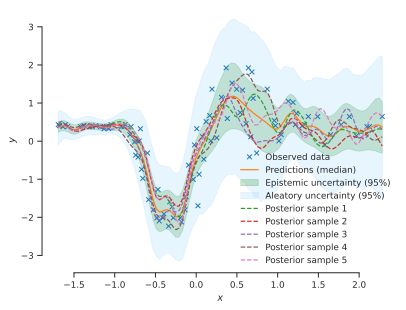

In [ ]:
# Select 5 random samples from the posterior
num_samples_to_plot = 5
sample_indices = np.random.choice(predictions.shape[0], num_samples_to_plot, replace=False)
posterior_samples = predictions[sample_indices]

# Plotting the results
fig, ax = plt.subplots()
ax.plot(X.numpy(), Y.numpy(), 'x', label="Observed data")
ax.plot(xs.numpy().flatten(), p_500.flatten(), label="Predictions (median)")
ax.fill_between(xs.numpy().flatten(), p_025.flatten(), p_975.flatten(), color='g', alpha=0.2, label="Epistemic uncertainty (95%)")
ax.fill_between(xs.numpy().flatten(), ap_025.flatten(), ap_975.flatten(), color='lightskyblue', alpha=0.2, label="Aleatory uncertainty (95%)")

# Plot the posterior samples
for i, sample in enumerate(posterior_samples):
    ax.plot(xs.numpy().flatten(), sample.flatten(), linestyle='--', label=f"Posterior sample {i+1}")

ax.set(xlabel="$x$", ylabel="$y$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)
plt.show()

### Part B.VI

Plot the estimated noise standard deviation as a function of of the input along with a 95% credible interval.

**Answer:**

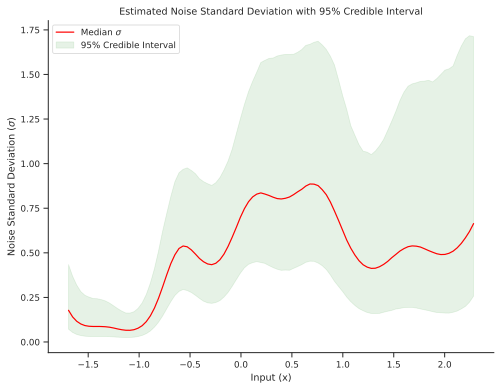

In [ ]:
# Compute percentiles for noise standard deviation
sigma_025, sigma_500, sigma_975 = np.percentile(post_pred["sigma"], [2.5, 50, 97.5], axis=0)

# Plot the estimated noise standard deviation
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(xs.flatten(), sigma_500.flatten(), 'r-', label=r"Median $\sigma$")
ax.fill_between(xs.flatten(), sigma_025.flatten(), sigma_975.flatten(), color='g', alpha=0.1, label="95% Credible Interval")

ax.set_xlabel("Input (x)")
ax.set_ylabel("Noise Standard Deviation ($\sigma$)")

ax.legend(loc="upper left")
sns.despine(trim=False)
plt.title("Estimated Noise Standard Deviation with 95% Credible Interval")
plt.show()


### Part B.VII

Which model do you prefer? Why?

**Answer:**
It is better to choose the heteroskedastic model. This preference is because the heteroskedastic model can more accurately capture varying noise levels within the dataset. Specifically, if the data exhibits different variances across different strata or segments, the heteroskedastic model will provide a more precise representation and potentially yield better predictive performance and more reliable inference. The 'motor.dat' dataset, for instance, consists of 94 data points divided into three strata, each with its own variance residual estimate. This indicates varying noise levels across the dataset. Hence, I prefer the heteroskedastic model as it can more effectively capture these variations
<br>



### Part B.IX

Can you think of any way to improve the model?
Go crazy! This is the last homework assignment!
There is no right or wrong answer here.
But if you have a good idea, we will give you extra credit.

Below is an attempt to add the residual variance as noise in the model.

Iteration: 0 Loss: 235.2681884765625
Iteration: 1000 Loss: 181.46273803710938
Iteration: 2000 Loss: 174.09762573242188
Iteration: 3000 Loss: 190.0090789794922
Iteration: 4000 Loss: 167.44100952148438
Iteration: 5000 Loss: 182.38499450683594
Iteration: 6000 Loss: 187.0212860107422
Iteration: 7000 Loss: 182.5631103515625
Iteration: 8000 Loss: 192.0309295654297
Iteration: 9000 Loss: 185.08993530273438
Iteration: 10000 Loss: 167.17120361328125
Iteration: 11000 Loss: 181.4172821044922
Iteration: 12000 Loss: 196.0712127685547
Iteration: 13000 Loss: 189.82716369628906
Iteration: 14000 Loss: 180.20957946777344
Iteration: 15000 Loss: 169.49229431152344
Iteration: 16000 Loss: 168.0067596435547
Iteration: 17000 Loss: 171.5547332763672
Iteration: 18000 Loss: 207.374755859375
Iteration: 19000 Loss: 191.61932373046875


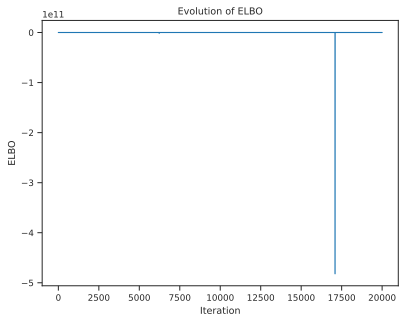

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load and preprocess data
data = np.loadtxt('motor.dat')
scaler = StandardScaler()
data = scaler.fit_transform(data)
X = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
Y = torch.tensor(data[:, 1], dtype=torch.float32)
V = torch.tensor(data[:, 3], dtype=torch.float32).unsqueeze(1)

def great_model(X, y, V, num_centers=50):
    num_data = X.shape[0]
    with pyro.plate("centers", num_centers):
        alpha = pyro.sample("alpha", dist.Exponential(1.0))
        w = pyro.sample("w", dist.Normal(0.0, alpha))

        alpha_noise = pyro.sample("alpha_noise", dist.Exponential(1.0))
        w_noise = pyro.sample("w_noise", dist.Normal(0.0, alpha_noise))

    ell = pyro.sample("ell", dist.Exponential(1.0))
    ell_noise = pyro.sample("ell_noise", dist.Exponential(1.0))

    x_centers = torch.linspace(X.min(), X.max(), num_centers).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(X)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(X)

    sigma_base = torch.exp(Phi_noise @ w_noise)
    sigma = torch.nn.functional.softplus(sigma_base * (1 + V.squeeze(-1))) + 1e-6
    great_model_mean = Phi @ w

    with pyro.plate("data", num_data):
        pyro.sample("y", dist.Normal(great_model_mean, sigma), obs=y)

    return {
        "x_centers": x_centers,
        "Phi": Phi,
        "Phi_noise": Phi_noise,
        "w": w,
        "w_noise": w_noise,
        "ell": ell,
        "ell_noise": ell_noise,
        "sigma": sigma
    }


num_iterations = 20_000
elbos, param_store = train(great_model, guide, (X, Y, V), num_iterations)

# Plot the evolution of the ELBO
plt.figure()
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("Evolution of ELBO")
plt.show()
sns.despine(trim=True)

In [ ]:
def predictive_model(X, y, V, num_centers=50):
    params = great_model(X, y, V, num_centers)

    w = params["w"]
    w_noise = params["w_noise"]
    ell = params["ell"]
    ell_noise = params["ell_noise"]
    sigma = params["sigma"]
    x_centers = params["x_centers"]
    xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
    Phi = RadialBasisFunctions(x_centers, ell)(xs)
    Phi_noise = RadialBasisFunctions(x_centers, ell_noise)(xs)
    predictions = pyro.deterministic("predictions", Phi @ w)
    sigma = pyro.deterministic("sigma", torch.exp(Phi_noise @ w_noise))
    predictions_with_noise = pyro.sample("predictions_with_noise", dist.Normal(predictions, sigma))
    return locals()

In [ ]:
# Here is how to make the predictions. Just change the number of samples to the right number.
post_pred = pyro.infer.Predictive(predictive_model, guide=guide, num_samples=10_000)(X, Y, V)

# We will predict here:
xs = torch.linspace(X.min(), X.max(), 100).unsqueeze(-1)
# You can extract the predictions from post_pred like this:
predictions = post_pred["predictions"]
# Note that we extracted the deterministic node called "predictions" from the great_model.
# Get the epistemic uncertainty in the usual way:
p_500, p_025, p_975 = np.percentile(predictions, [50, 2.5, 97.5], axis=0)
# Extract predictions with noise
predictions_with_noise = post_pred["predictions_with_noise"].detach().numpy()
# Get the aleatory uncertainty
ap_025, ap_975 = np.percentile(predictions_with_noise, [2.5, 97.5], axis=0)

num_samples_to_plot = 5
sample_indices = np.random.choice(predictions.shape[0], num_samples_to_plot, replace=False)
posterior_samples = predictions[sample_indices]

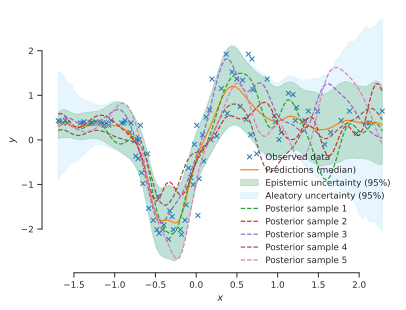

In [ ]:
# Plotting the results
fig, ax = plt.subplots()
ax.plot(X.numpy(), Y.numpy(), 'x', label="Observed data")
ax.plot(xs.numpy().flatten(), p_500.flatten(), label="Predictions (median)")
ax.fill_between(xs.numpy().flatten(), p_025.flatten(), p_975.flatten(), color='g', alpha=0.2, label="Epistemic uncertainty (95%)")
ax.fill_between(xs.numpy().flatten(), ap_025.flatten(), ap_975.flatten(), color='lightskyblue', alpha=0.2, label="Aleatory uncertainty (95%)")

for i, sample in enumerate(posterior_samples):
    ax.plot(xs.numpy().flatten(), sample.flatten(), linestyle='--', label=f"Posterior sample {i+1}")

ax.set(xlabel="$x$", ylabel="$y$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!sudo apt-get install inkscape texlive-xetex

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [908 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,118 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubun

In [ ]:
!sudo apt-get install pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-luatex pandoc-citeproc context wkhtmltopdf librsvg2-bin groff ghc
  nodejs php python libjs-mathjax libjs-katex citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc
  pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 48 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 pando

In [ ]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_Homework7_PartB_final.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_Homework7_PartB_final.ipynb to pdf
Failed to get connection
** (inkscape:11087): CRITICAL **: 00:36:59.356: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:11087): CRITICAL **: 00:36:59.356: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:11087): CRITICAL **: 00:36:59.356: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:11091): CRITICAL **: 00:36:59.747: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:11091): CRITICAL **: 00:36:59.747: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:11091): CRITICAL **: 00:36:59.747: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:11095): CRITICAL **: 00:37:00.057: dbus_g_proxy_new_for_name: assertion 'connection